<a href="https://colab.research.google.com/github/Aqfa07/ML-Project/blob/main/Project%20011%3A%20Image%20Normalization%20Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

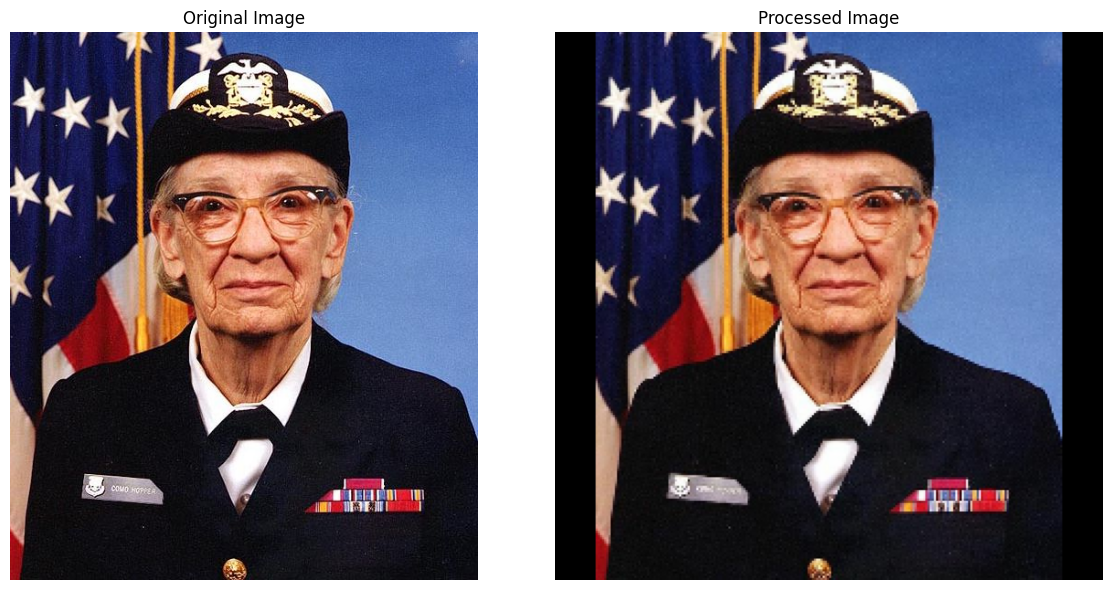

Processed image shape: (256, 256, 3)
Processed image dtype: <dtype: 'float32'>
Pixel value range: [0.000, 1.000]


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

class ImageNormalizer:
    def __init__(self, target_size=(224, 224), normalize=True, data_format='channels_last'):
        """
        Initialize the image normalizer

        Args:
            target_size: Tuple (height, width) for resizing
            normalize: Whether to normalize to [0,1] or standardize
            data_format: 'channels_last' (default) or 'channels_first'
        """
        self.target_size = target_size
        self.normalize = normalize
        self.data_format = data_format
        self.mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)  # ImageNet mean
        self.std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)   # ImageNet std

    def load_image(self, path):
        """Load and decode image from file path"""
        img_raw = tf.io.read_file(path)
        try:
            img = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
        except:
            img = tf.image.decode_jpeg(img_raw, channels=3)
        img.set_shape([None, None, 3])
        return img

    def resize_image(self, image):
        """Resize image maintaining aspect ratio with padding if needed"""
        # Calculate padding needed to maintain aspect ratio
        h = tf.cast(tf.shape(image)[0], tf.float32)
        w = tf.cast(tf.shape(image)[1], tf.float32)
        target_h, target_w = tf.cast(self.target_size[0], tf.float32), tf.cast(self.target_size[1], tf.float32)

        scale = tf.minimum(target_h/h, target_w/w)
        new_h = tf.cast(h * scale, tf.int32)
        new_w = tf.cast(w * scale, tf.int32)

        # Resize
        image = tf.image.resize(image, [new_h, new_w])

        # Pad if needed
        pad_h = tf.cast(target_h, tf.int32) - new_h
        pad_w = tf.cast(target_w, tf.int32) - new_w

        image = tf.image.pad_to_bounding_box(
            image,
            offset_height=pad_h//2,
            offset_width=pad_w//2,
            target_height=tf.cast(target_h, tf.int32),
            target_width=tf.cast(target_w, tf.int32)
        )
        return image

    def normalize_image(self, image):
        """Normalize or standardize image"""
        image = tf.cast(image, tf.float32)
        if self.normalize:
            image = image / 255.0
        else:
            # Standardize using ImageNet stats
            image = image / 255.0
            image = (image - self.mean) / self.std

        if self.data_format == 'channels_first':
            image = tf.transpose(image, perm=[2, 0, 1])

        return image

    def augment_image(self, image):
        """Apply random augmentations"""
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
        return image

    def preprocess(self, path, augment=False):
        """Complete preprocessing pipeline"""
        image = self.load_image(path)
        image = self.resize_image(image)
        if augment:
            image = self.augment_image(image)
        image = self.normalize_image(image)
        return image

# Example usage
if __name__ == "__main__":
    # Download example image
    image_path = tf.keras.utils.get_file(
        "grace_hopper.jpg",
        "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg"
    )

    # Create normalizer instance
    normalizer = ImageNormalizer(target_size=(256, 256), normalize=True)

    # Process image
    image = normalizer.preprocess(image_path, augment=False)

    # Display results
    plt.figure(figsize=(12, 6))

    # Show original
    plt.subplot(1, 2, 1)
    original = plt.imread(image_path)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    # Show processed
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title("Processed Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Processed image shape: {image.shape}")
    print(f"Processed image dtype: {image.dtype}")
    print(f"Pixel value range: [{tf.reduce_min(image):.3f}, {tf.reduce_max(image):.3f}]")